# TODO:
- Clean (see other notebook)
- Create "distance from Seattle" feature

In [266]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.stats as st
# import pymc3 as pm
import seaborn as sns

# enables inline plots, without it plots don't show up in the notebook
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
# %config InlineBackend.figure_format = 'png'
# mpl.rcParams['figure.dpi']= 300

In [267]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 25)
pd.set_option('display.precision', 3)

In [268]:
import pickle
def load_pd_pkl(file):
    import pandas as pd
    try:
        with open(f"{file}.pkl",'rb') as picklefile:
            return pickle.load(picklefile)
    except FileNotFoundError:
        df = pd.read_csv(f"{file}.csv")
        with open(f"{file}.pkl", 'wb') as picklefile:
            pickle.dump(df, picklefile)
        return df

In [269]:
df = load_pd_pkl('data/raw_wta_df')

In [270]:
#df.to_csv('data/raw_wta_df.csv')

In [271]:
df.shape

(3555, 31)

In [272]:
df.reset_index(drop=True, inplace=True)

In [273]:
df['votes'] = df['votes'].astype(int)
df['countreports'] = df['countreports'].astype(int)
df['rating'] = df['rating'].astype(float)
df['length'] = df['length'].astype(float)
df['gain'] = df['gain'].astype(float)
df['hpoint'] = df['hpoint'].astype(float)
df['lat'] = df['lat'].astype(float)
df['long'] = df['long'].astype(float)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3555 entries, 0 to 3554
Data columns (total 31 columns):
name                     3555 non-null object
region                   3555 non-null object
subregion                2942 non-null object
votes                    3555 non-null int64
rating                   3555 non-null float64
length                   2361 non-null float64
lengthtype               2219 non-null object
gain                     1854 non-null float64
hpoint                   1946 non-null float64
fee                      2013 non-null object
lat                      2607 non-null float64
long                     2607 non-null float64
trailhead1               2961 non-null object
trailhead2               1081 non-null object
author1                  1291 non-null object
author2                  1291 non-null object
countreports             3555 non-null int64
Wildflowers/Meadows      3555 non-null int64
Mountain views           3555 non-null int64
Dogs allowed on l

In [274]:
# Clean hikes which faultily have the 'hpoint' assigned to the "length" to NaN
df.loc[df['length'] == df['hpoint'], 'length'] = np.nan

In [275]:
# Good! All length types exist with a length preceding it.
df[df['length'].notna() & df['length'].isna()]

,name,region,subregion,votes,rating,length,lengthtype,gain,hpoint,fee,lat,long,trailhead1,trailhead2,author1,author2,countreports,Wildflowers/Meadows,Mountain views,Dogs allowed on leash,Established campsites,Waterfalls,Good for kids,Fall foliage,Ridges/passes,Wildlife,Old growth,Summits,Lakes,Rivers,Coast


In [276]:
# Accurately update length type of "of" to "miles_of_trails" like on website
df[df.lengthtype == "of"]
df.loc[df['lengthtype'] == "of", 'lengthtype'] = "miles_of_trails"

# Clean hikes which faultily have the 'gain assigned to the "length" to NaN
df.loc[df['length'] == df['gain'], 'length'] = np.nan
df[df.length == df.gain].shape

# rename author1 and author2
df.rename(columns={'author1': 'org_author', "author2":"author"},inplace=True)

# do some renaming of dfs and create new one dropping a few columns and all NaNs
old_df = df.copy()
df = df.drop(columns=['trailhead2','org_author', 'author'])
df.dropna(inplace=True)

# drop hikes without any votes and ratings remaining
df = df.loc[df['votes'] != 0, :]

### try drop subregion, fee, lat & long, org_author & author
- subregion adds back 18
- fee 71
- lat & long 23
- org_author & author 378

In [321]:
##### consider limitations on extreme values in length and gain at this point

In [ ]:
##### should I require votes to be above a certain threshold? 1-5?

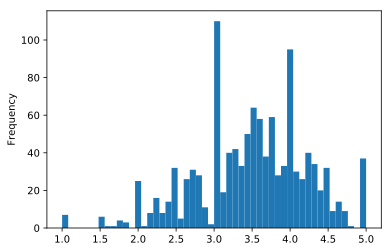

In [376]:
df.rating.plot.hist(50)

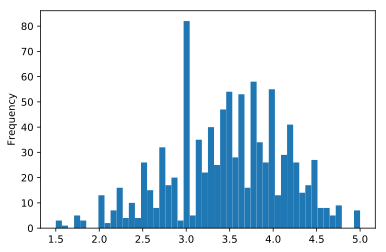

In [372]:
df[df.votes > 3].rating.plot.hist(50)

In [377]:
df[df.votes > 3].describe()

,votes,rating,length,gain,hpoint,lat,long,countreports,Wildflowers/Meadows,Mountain views,Dogs allowed on leash,Established campsites,Waterfalls,Good for kids,Fall foliage,Ridges/passes,Wildlife,Old growth,Summits,Lakes,Rivers,Coast
count,973.000,973.000,973.000,973.000,973.000,973.000,973.000,973.000,973.000,973.000,973.000,973.000,973.000,973.000,973.000,973.000,973.000,973.000,973.000,973.000,973.000,973.000
mean,14.787,3.479,8.359,1719.831,3995.255,47.459,-121.605,120.010,0.531,0.659,0.495,0.261,0.177,0.343,0.229,0.288,0.388,0.319,0.219,0.354,0.296,0.042
std,25.423,0.663,7.513,1603.641,2165.295,0.791,1.145,199.716,0.499,0.474,0.500,0.439,0.382,0.475,0.421,0.453,0.488,0.466,0.414,0.478,0.457,0.201
min,4.000,1.500,0.250,10.000,10.000,45.577,-124.683,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
25%,5.000,3.000,4.000,500.000,2028.000,46.911,-122.070,21.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
50%,7.000,3.500,7.000,1400.000,4400.000,47.516,-121.607,53.000,1.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
75%,14.000,4.000,10.400,2550.000,5730.000,47.977,-121.093,126.000,1.000,1.000,1.000,1.000,0.000,1.000,0.000,1.000,1.000,1.000,0.000,1.000,1.000,0.000
max,294.000,5.000,117.000,26351.000,12276.000,48.995,-117.078,1697.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000


In [374]:
df.describe()

,votes,rating,length,gain,hpoint,lat,long,countreports,Wildflowers/Meadows,Mountain views,Dogs allowed on leash,Established campsites,Waterfalls,Good for kids,Fall foliage,Ridges/passes,Wildlife,Old growth,Summits,Lakes,Rivers,Coast
count,1150.000,1150.000,1150.000,1150.000,1150.000,1150.000,1150.000,1150.000,1150.000,1150.000,1150.000,1150.000,1150.000,1150.000,1150.000,1150.000,1150.000,1150.000,1150.000,1150.000,1150.000,1150.000
mean,12.803,3.491,8.190,1658.423,3862.960,47.445,-121.569,104.282,0.525,0.642,0.515,0.250,0.169,0.361,0.246,0.272,0.395,0.313,0.229,0.334,0.296,0.045
std,23.843,0.739,7.281,1570.078,2219.094,0.816,1.235,187.523,0.500,0.480,0.500,0.433,0.375,0.480,0.431,0.445,0.489,0.464,0.420,0.472,0.457,0.208
min,1.000,1.000,0.160,10.000,10.000,45.560,-124.683,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
25%,4.000,3.000,4.000,500.000,1900.000,46.898,-122.115,15.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
50%,6.000,3.500,7.000,1300.000,4200.000,47.516,-121.628,41.000,1.000,1.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
75%,12.000,4.000,10.230,2500.000,5700.000,47.977,-121.092,107.000,1.000,1.000,1.000,0.000,0.000,1.000,0.000,1.000,1.000,1.000,0.000,1.000,1.000,0.000
max,294.000,5.000,117.000,26351.000,12276.000,48.995,-115.936,1697.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000


In [373]:
d = {i: len(df[i].unique()) for i in df.columns}
d

{'name': 1137,
 'region': 11,
 'subregion': 51,
 'votes': 85,
 'rating': 178,
 'length': 199,
 'lengthtype': 3,
 'gain': 321,
 'hpoint': 563,
 'fee': 12,
 'lat': 1001,
 'long': 1012,
 'trailhead1': 870,
 'countreports': 305,
 'Wildflowers/Meadows': 2,
 'Mountain views': 2,
 'Dogs allowed on leash': 2,
 'Established campsites': 2,
 'Waterfalls': 2,
 'Good for kids': 2,
 'Fall foliage': 2,
 'Ridges/passes': 2,
 'Wildlife': 2,
 'Old growth': 2,
 'Summits': 2,
 'Lakes': 2,
 'Rivers': 2,
 'Coast': 2}

In [280]:
# There are 7 passes, and also none and n/a
df.fee.unique()

array(['Northwest Forest Pass', 'None', 'National Park Pass',
       'Discover Pass', nan, 'Refuge Entrance Pass',
       'National Monument Fee', 'None, Northwest Forest Pass',
       'Oregon State Parks Day-Use',
       'National Monument Fee, Sno-Parks Permit', 'Sno-Parks Permit',
       'Discover Pass, Sno-Parks Permit',
       'Northwest Forest Pass, Sno-Parks Permit'], dtype=object)

In [144]:
authors = df.groupby('author2').agg(['count','mean']).sort_values(('votes','count'), ascending=False)

In [150]:
orgs = df.groupby('author1').agg(['count','mean']).sort_values(('votes','count'), ascending=False)
orgs

votes         rating        length          gain            \
                   count    mean  count   mean  count    mean count      mean   
author1                                                                         
WTA Correspondents   699  13.775    699  2.884    695  18.801   644  1604.846   
WTA Community        366   6.552    366  2.928    363  17.326   296  1968.416   
WTA Staff            226   9.500    226  3.028    226   7.376   197  1368.741   

                   hpoint             lat          long          countreports  \
                    count      mean count    mean count     mean        count   
author1                                                                         
WTA Correspondents    631  3558.599   667  47.568   667 -121.314          699   
WTA Community         290  3759.476   358  47.427   358 -121.525          366   
WTA Staff             201  3044.045   225  47.250   225 -121.894          226   

                            Wildflowers/Meadows        Mountain views         \
                       mean               count   mean          count   mean   
author1                                                                        
WTA Correspondents  113.979                 699  0.569            699  0.589   
WTA Community        51.574                 366  0.432            366  0.560   
WTA Staff            80.261                 226  0.429            226  0.624   

                   Dogs allowed on leash        Established campsites         \
                                   count   mean                 count   mean   
author1                                                                        
WTA Correspondents                   699  0.611                   699  0.219   
WTA Community                        366  0.598                   366  0.224   
WTA Staff                            226  0.593                   226  0.239   

                   Waterfalls        Good for kids        Fall foliage         \
                        count   mean         count   mean        count   mean   
author1                                                                         
WTA Correspondents        699  0.172           699  0.476          699  0.333   
WTA Community             366  0.186           366  0.448          366  0.279   
WTA Staff                 226  0.168           226  0.442          226  0.305   

                   Ridges/passes        Wildlife        Old growth         \
                           count   mean    count   mean      count   mean   
author1                                                                     
WTA Correspondents           699  0.233      699  0.466        699  0.282   
WTA Community                366  0.230      366  0.377        366  0.276   
WTA Staff                    226  0.235      226  0.465        226  0.301   

                   Summits        Lakes        Rivers        Coast         
                     count   mean count   mean  count   mean count   mean  
author1                                                                    
WTA Correspondents     699  0.215   699  0.329    699  0.290   699  0.049  
WTA Community          366  0.180   366  0.292    366  0.358   366  0.060  
WTA Staff              226  0.181   226  0.345    226  0.305   226  0.106

In [148]:
authors[authors['rating','mean'] > 3.5]

votes          rating        length          gain  \
                      count     mean  count   mean  count    mean count   
author2                                                                   
Ken Giesbers             40   14.200     40  3.581     40   7.335    40   
Linda Roe                28   24.536     28  3.510     28   5.661    27   
Paul Kriloff             24   47.708     24  3.797     24  10.279    24   
Mason White              11   19.364     11  3.741     11  10.145    11   
Nate and Jer Barnes      11   15.455     11  3.705     11   6.409    11   
Mike Scavezze            11   19.818     11  4.155     11   7.855     9   
Melissa Ozbek             7   12.429      7  3.700      7   3.643     5   
Susan Elderkin            7    8.714      7  3.597      7   6.086     7   
Joan Burton               5    4.400      5  3.646      5   7.800     5   
Conor Dempsey             5  110.800      5  4.140      5   7.040     5   
Steven Payne              5   20.800      5  3.688      5   8.100     5   
Kim Hull                  4   39.750      4  4.050      4   7.875     4   
...                     ...      ...    ...    ...    ...     ...   ...   
Loren Drummond            2   11.500      2  3.675      2   3.600     2   
Alan Bauer                1    7.000      1  4.290      1   9.000     1   
Alex Mesick               1   17.000      1  3.530      1   6.500     0   
Walter Henze              1    1.000      1  4.000      1  24.000     1   
Ashley Morrison           1   10.000      1  3.700      1  10.000     1   
Pam and Paul Kaperick     1   55.000      1  4.380      1  11.500     1   
Lunnel Haught             1    7.000      1  3.570      1   5.500     0   
Dennis Graver             1   20.000      1  3.600      1  14.400     1   
Janelle Jones Walker      1   19.000      1  3.580      1   7.000     1   
Cindy Clark               1   15.000      1  4.070      1   8.000     1   
Cape Horn Conservancy     1   11.000      1  3.550      1   7.200     1   
Harper Meyerson           1    3.000      1  3.670      1   3.000     0   

                                hpoint             lat          long           \
                           mean  count      mean count    mean count     mean   
author2                                                                         
Ken Giesbers           1906.000     40  4816.250    40  47.226    40 -121.804   
Linda Roe               650.333     27  2002.000    28  48.164    28 -121.793   
Paul Kriloff           3724.583     24  6052.417    24  47.928    24 -121.168   
Mason White            2651.818     11  5082.545    11  47.836    11 -123.220   
Nate and Jer Barnes    1291.636     11  3715.909    11  47.311    11 -121.749   
Mike Scavezze          1777.778      9  4298.778    11  47.856    11 -121.938   
Melissa Ozbek           570.000      4  3186.000     7  47.853     7 -121.678   
Susan Elderkin          475.714      6  3633.333     7  47.287     7 -122.453   
Joan Burton            1040.000      5  4387.800     5  47.603     5 -121.842   
Conor Dempsey          2170.000      5  4103.400     5  47.554     5 -121.703   
Steven Payne           1310.000      5  3895.400     5  47.029     5 -122.147   
Kim Hull               2487.500      4  6690.250     4  47.188     4 -121.196   
...                         ...    ...       ...   ...     ...   ...      ...   
Loren Drummond          850.000      2  5553.000     2  47.344     2 -121.327   
Alan Bauer             1700.000      1  5900.000     1  46.141     1 -121.598   
Alex Mesick                 NaN      1   650.000     1  46.902     1 -123.064   
Walter Henze           3000.000      1  3930.000     1  48.903     1 -119.424   
Ashley Morrison        2300.000      1  6900.000     1  46.288     1 -121.552   
Pam and Paul Kaperick  3489.000      1  6000.000     1  47.828     1 -123.041   
Lunnel Haught               NaN      1  2300.000     1  47.417     1 -117.531   
Dennis Graver          1450.000      1  3450.000     1  47